In [1]:
# Import required libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols
import geopandas
import pycountry

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Read all the required csv files
products_inital = pd.read_csv('data/Amazon_Products.csv')
market_cap = pd.read_csv('data/Market_Cap.csv')
revenue = pd.read_csv('data/Revenue.csv')

del products_inital['Unnamed: 0']

Amazon_Products can be downloaded from: https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset

## 1. Data Manipulation

In [5]:
market_cap.head()

,Rank,Name,Symbol,marketcap,price (USD),country
0,1,Apple,AAPL,2711595515904,173.44,United States
1,2,Microsoft,MSFT,2455517265920,330.53,United States
2,3,Saudi Aramco,2222.SR,2142682045482,8.86,Saudi Arabia
3,4,Alphabet (Google),GOOG,1757090676736,140.12,United States
4,5,Amazon,AMZN,1326456373248,128.56,United States


In [6]:
revenue.head()

,Rank,Name,Symbol,revenue_ttm,price (USD),country
0,1,Walmart,WMT,630794000000,163.25,United States
1,2,Amazon,AMZN,538046000000,128.56,United States
2,3,Saudi Aramco,2222.SR,535542404351,8.86,Saudi Arabia
3,4,Sinopec,600028.SS,469298554437,0.77,China
4,5,PetroChina,601857.SS,441339399414,1.06,China


In [7]:
# Merge market cap and revenue dataframes
mcap_revenue = pd.merge(market_cap, revenue, on='Name', how='inner')

In [8]:
# Drop columns that will not be considered for analysis
mcap_revenue.drop(['Rank_x', 'Rank_y', 'Symbol_x', 'Symbol_y', 'country_y', 'price (USD)_x', 'price (USD)_y'], 
                  axis=1, inplace=True)
# Rename columns
mcap_revenue.columns = ['brand', 'marketcap', 'country', 'revenue_ttm']
mcap_revenue.head()

,brand,marketcap,country,revenue_ttm
0,Apple,2711595515904,United States,383933000000
1,Microsoft,2455517265920,United States,211915000000
2,Saudi Aramco,2142682045482,Saudi Arabia,535542404351
3,Alphabet (Google),1757090676736,United States,289531000000
4,Amazon,1326456373248,United States,538046000000


In [9]:
# Extract brand name from parenthesis
mcap_revenue['brand'] = mcap_revenue['brand'].str.extract('\((.*?)\)', expand=False).fillna(mcap_revenue['brand'])
mcap_revenue['brand'] = mcap_revenue['brand'].str.lower().str.capitalize()
mcap_revenue.head()

,brand,marketcap,country,revenue_ttm
0,Apple,2711595515904,United States,383933000000
1,Microsoft,2455517265920,United States,211915000000
2,Saudi aramco,2142682045482,Saudi Arabia,535542404351
3,Google,1757090676736,United States,289531000000
4,Amazon,1326456373248,United States,538046000000


### Pre-processing

In [10]:
products_inital.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990"
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990"
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990"
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990"
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790"


In [11]:
# Removing the ₹ sign
products_inital["discount_price"] = products_inital["discount_price"].str.split(" ", expand = True).get(0).str.split("₹", expand = True).get(1)
products_inital["actual_price"] = products_inital["actual_price"].str.split(" ", expand = True).get(0).str.split("₹", expand = True).get(1)

# Change commas to dots and change the type to float
products_inital['discount_price'] = products_inital["discount_price"].str.replace(',', '').astype(float)
products_inital["actual_price"] = products_inital["actual_price"].str.replace(',', '').astype(float)

In [12]:
# Check unique values in ratings column
products_inital['ratings'].unique()

array(['4.2', '4.0', '4.1', '4.3', '3.9', '3.8', '3.5', nan, '4.6', '3.3',
       '3.4', '3.7', '2.9', '5.0', '4.4', '3.6', '2.7', '4.5', '3.0',
       '3.1', '3.2', '4.8', '4.7', '2.5', '1.0', '2.6', '2.8', '2.3',
       '1.7', 'Get', '1.8', '2.4', '4.9', '2.2', '1.6', '1.9', '2.0',
       '1.4', '2.1', 'FREE', '1.2', '1.3', '1.5', '₹68.99', '₹65', '1.1',
       '₹70', '₹100', '₹99', '₹2.99'], dtype=object)

In [13]:
# Replace certain values in the 'ratings' column of the 'products' dataframe with '0.0'
products_inital['ratings'] = products_inital['ratings'].replace(['Get','FREE','₹68.99', '₹65','₹70', '₹100', '₹99', '₹2.99'], '0.0')
products_inital['ratings'] = products_inital["ratings"].astype(float)
products_inital['ratings'].unique()

array([4.2, 4. , 4.1, 4.3, 3.9, 3.8, 3.5, nan, 4.6, 3.3, 3.4, 3.7, 2.9,
       5. , 4.4, 3.6, 2.7, 4.5, 3. , 3.1, 3.2, 4.8, 4.7, 2.5, 1. , 2.6,
       2.8, 2.3, 1.7, 0. , 1.8, 2.4, 4.9, 2.2, 1.6, 1.9, 2. , 1.4, 2.1,
       1.2, 1.3, 1.5, 1.1])

In [14]:
products_inital.no_of_ratings

0         2,255
1         2,948
2         1,206
3            69
4           630
          ...  
551580        9
551581        2
551582        1
551583       37
551584        5
Name: no_of_ratings, Length: 551585, dtype: object

In [15]:
# Filters products with numeric ratings
products_inital = products_inital[products_inital['no_of_ratings'].astype(str).str[0].str.isdigit()]

# Converts the 'no_of_ratings' column to float after removing commas
products_inital["no_of_ratings"] = products_inital["no_of_ratings"].str.replace(',', '').astype(float)

### Check NaN values

In [16]:
# Check for null values
products_inital.isnull().sum()

name                  0
main_category         0
sub_category          0
image                 0
link                  0
ratings               0
no_of_ratings         0
discount_price    34595
actual_price       6761
dtype: int64

In [17]:
# Drop rows with null values
products_inital = products_inital.dropna(subset=['actual_price','discount_price'])

### Creating `Discount` related columns 

In [18]:
# Make column with discount net value and discounting percent 
products_inital['discount_value'] = products_inital['actual_price'] - products_inital['discount_price']
products_inital['discounting_percent'] = 1 - products_inital['discount_price']/products_inital['actual_price']

In [19]:
products_inital['brand'] = products_inital['name'].str.split(' ').str[0]
print(products_inital['brand'])
products_inital['brand'] = products_inital['brand'].str.lower().str.capitalize()

0              Lloyd
1                 LG
2                 LG
3                 LG
4            Carrier
             ...    
551579            BE
551580        Adidas
551581       Redwolf
551582       Redwolf
551584    Mothercare
Name: brand, Length: 334963, dtype: object


In [20]:
# Merge all the dataframes
products = pd.merge(products_inital, mcap_revenue, on='brand', how='inner')

In [21]:
# Push the final dataset to a csv file
products.to_csv('final_dataset.csv')

In [22]:
products.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent,brand,marketcap,country,revenue_ttm
0,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630.0,34490.0,67790.0,33300.0,0.491223,Carrier,40331792384,United States,21821000000
1,Carrier 1 Ton 3 Star AI Flexicool Inverter Spl...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51sTXvsanQ...,https://www.amazon.in/Carrier-Flexicool-Invert...,4.1,674.0,30990.0,58190.0,27200.0,0.467434,Carrier,40331792384,United States,21821000000
2,Carrier 1.5 Ton 5 Star AI Flexicool Inverter S...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/61JtwWcAco...,https://www.amazon.in/Carrier-Flexicool-Conver...,4.0,568.0,41999.0,78490.0,36491.0,0.464913,Carrier,40331792384,United States,21821000000
3,Carrier 1.5 Ton 3 Star Fixed Speed Window AC( ...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/717wB+IneG...,https://www.amazon.in/Carrier-Window-Copper-Di...,4.3,201.0,30990.0,45090.0,14100.0,0.312708,Carrier,40331792384,United States,21821000000
4,Carrier 2 Ton 5 Star AI Flexicool Inverter Spl...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/61JtwWcAco...,https://www.amazon.in/Carrier-Flexicool-Conver...,3.9,69.0,52990.0,91690.0,38700.0,0.422074,Carrier,40331792384,United States,21821000000


## 2. Descriptive Analysis


### Get Summary Statistics

In [23]:
# Print numerical statistics of the products dataframe
print(products.describe())

            ratings  no_of_ratings  discount_price  actual_price  \
count  18390.000000   18390.000000    1.839000e+04  1.839000e+04   
mean       3.947227    2135.483904    6.537443e+03  9.935642e+03   
std        0.649333   17377.744145    1.864749e+04  2.567719e+04   
min        1.000000       1.000000    1.000000e+01  3.800000e+01   
25%        3.700000       8.000000    7.390000e+02  1.799000e+03   
50%        4.000000      54.000000    1.859000e+03  3.495000e+03   
75%        4.300000     384.000000    4.082750e+03  6.900000e+03   
max        5.000000  437652.000000    1.249990e+06  1.594900e+06   

       discount_value  discounting_percent     marketcap   revenue_ttm  
count    18390.000000         18390.000000  1.839000e+04  1.839000e+04  
mean      3398.198813             0.429599  2.881634e+11  1.218056e+11  
std       8071.438677             0.198819  5.274921e+11  2.038397e+11  
min          0.050000             0.000017  1.136061e+07  0.000000e+00  
25%        749.000000 

### Correlation between numerical variables

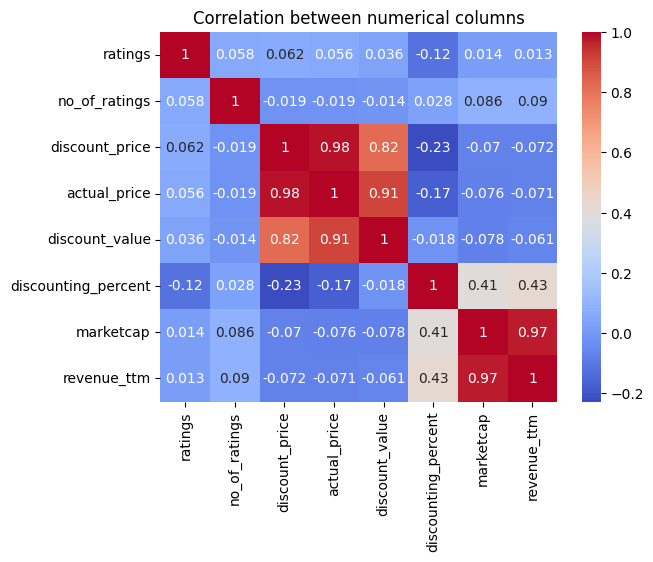

                      ratings  no_of_ratings  discount_price  actual_price  \
ratings              1.000000       0.058125        0.062102      0.056397   
no_of_ratings        0.058125       1.000000       -0.019306     -0.018563   
discount_price       0.062102      -0.019306        1.000000      0.983573   
actual_price         0.056397      -0.018563        0.983573      1.000000   
discount_value       0.035939      -0.014451        0.818676      0.908888   
discounting_percent -0.120825       0.027958       -0.227054     -0.170455   
marketcap            0.013908       0.086022       -0.070351     -0.075674   
revenue_ttm          0.012620       0.089798       -0.071804     -0.071398   

                     discount_value  discounting_percent  marketcap  \
ratings                    0.035939            -0.120825   0.013908   
no_of_ratings             -0.014451             0.027958   0.086022   
discount_price             0.818676            -0.227054  -0.070351   
actual_price 

In [24]:
# Check the corelation between the numerical columns
corr = products.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
# titles
plt.title("Correlation between numerical columns")
plt.show()
print(corr)

- Ratings: Ratings show a strong correlation with itself (1 as expected). It shows a very weak positive correlation with all other parameters, excluding discounting_percent where it shows a negative correlation but still very weak.



- Number of Ratings (no_of_ratings): This has a positive correlation with all variables except for discount_price, actual_price, and discount_value. The correlations, however, are all weak.



- Discount_price: It strongly correlates with the actual_price and discount_value, with correlations of 0.983573 and 0.818676 respectively. It shows a negative correlation with the rest of the variables.



- Actual_price: Strongly correlated with discount_price and discount_value. Generally, there's an inverse relationship with the rest of the variables.



- Discount_value: Highly positively correlated with actual_price and discount_price, and has negative or negligible correlations with all the other variables.



- Discounting_percent: It shows a positive correlation with marketcap and revenue_ttm, with the strongest being with revenue_ttm (0.426083). It negatively correlates with the rest, relatively strong with discount_price.



- Marketcap: Shows a strong correlation with revenue_ttm, and negative correlation with the rest of the variables.



- Revenue_ttm: Shows very strong correlation with marketcap , while negative correlation with the rest.

### Check for outliers in numerical columns

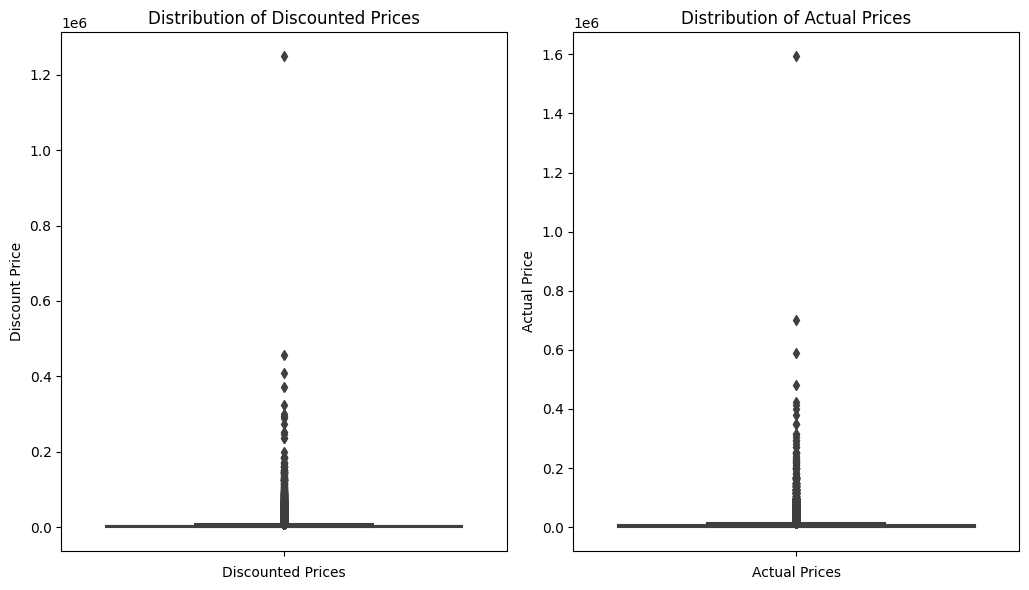

In [25]:
plt.figure(figsize=(15, 6))

# Subplot 1
plt.subplot(1, 3, 2)
sns.boxplot(y='discount_price', data=products)
plt.xlabel('Discounted Prices')
plt.ylabel('Discount Price')
plt.title('Distribution of Discounted Prices')

# Subplot 2
plt.subplot(1, 3, 3)
sns.boxplot(y='actual_price', data=products)
plt.xlabel('Actual Prices')
plt.ylabel('Actual Price')
plt.title('Distribution of Actual Prices')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

For Discounted Price:
- The lowest price in your dataset is 10.0 and the highest price reaches up to 1249990.0.
- The first quartile or 25th percentile is 739.0, which means that 25% of the prices are below this value.
- The median or 50th percentile is 1859.0, meaning that half of the prices are below this value and half are above. This is the middle value of the dataset.
- The third quartile or 75th percentile is 4082.75, meaning that 75% of the prices are below this value.
- The outlier values are relatively high compared to the rest of the dataset. These values are either above or below the typical range of discounted prices.

For Actual Price:
- The lowest price is 38.0 and the highest price is quite significant - up to 1594900.0.
- The first quartile is 1799.0, indicating that 25% of the prices are under this value.
- The median is 3495.0, so half of all prices are less than this and half are greater.
- The third quartile is 6900.0. This value shows us that 75% of the data falls below this price point.
- Outliers, again, are quite large, indicating that these particular prices are either exceptionally high or low compared to the majority.

Do note that the significant difference between the maximum values and the 75th percentile in both cases along with the high-value outliers indicates that the distribution is likely right-skewed. So, there are a few extremely high prices impacting the distribution, stretching it to the right.

### Count unique products in each category

In [26]:
# Check for unique categories in main_category column
print(products['main_category'].value_counts())

main_category
men's shoes                4350
tv, audio & cameras        3079
stores                     2211
men's clothing             2124
appliances                 2022
women's clothing           1184
accessories                1105
home & kitchen              576
sports & fitness            531
kids' fashion               327
women's shoes               261
beauty & health             187
car & motorbike             107
toys & baby products         83
bags & luggage               74
grocery & gourmet foods      74
industrial supplies          68
music                        21
pet supplies                  6
Name: count, dtype: int64


In [27]:
# Check for unique categories in sub_category column
print(products['sub_category'].value_counts())

sub_category
Casual Shoes             2171
Sports Shoes             1926
Men's Fashion            1191
All Electronics          1109
T-shirts & Polos         1017
                         ... 
Dog supplies                2
Rucksacks                   1
Fashion Sales & Deals       1
Travel Duffles              1
Kids' Watches               1
Name: count, Length: 105, dtype: int64


### Visualize the distribution of ratings

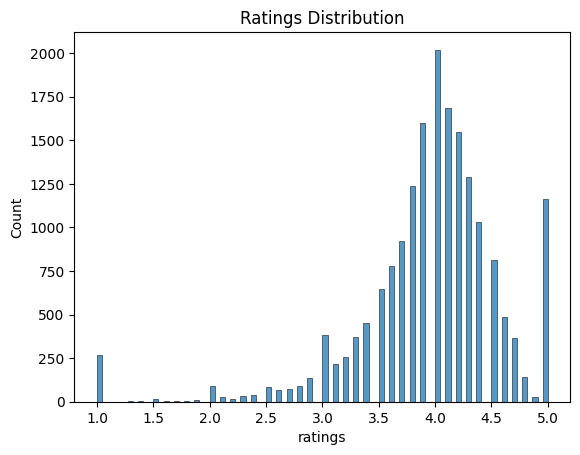

In [28]:
# Plot histogram for ratings column
sns.histplot(data=products, x='ratings')
plt.title('Ratings Distribution')
plt.show()

- Most products in your dataset are likely rated highly, i.e., most ratings are on the high end of the scale.

- The mean (average) rating is less than the median, as the lower values (less frequent low ratings) pull down the average.

- The mode (most frequent rating) is higher than both the median and mean since the majority of ratings are concentrated at the higher end.

- There are relatively fewer low ratings (indicated by the long left tail), but these can have a significant impact on the average rating.

### Visualize the top 10 brands with most products

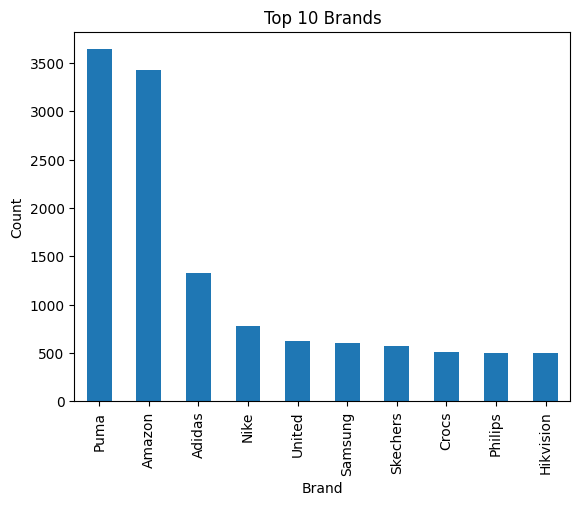

In [29]:
# Top 10 brands with highest number of products
products['brand'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

- Puma is the brand with the most items, with a count of 3640. 

- Amazon is the second most common brand, with 3424 items.

- Adidas comes in third with 1332 items.

- Nike is the fourth position with 783 items.

- United has 621 items, while Samsung has 600 items.

- Skechers contributes 570 items to the dataset.

- Crocs and Philips have a very close number of items, with 508 and 503 respectively.

- Hikvision has the 10th most items, with a count of 496.

### Check the average 'ratings' for the top 10 brands with the most products

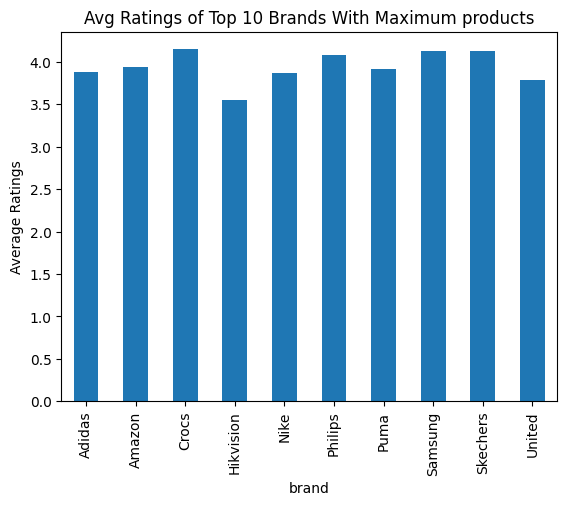

In [30]:
# Top 10 brands with highest number of ratings
top_brands = products['brand'].value_counts().index[:10]
products[products['brand'].isin(top_brands)].groupby('brand')['ratings'].mean().plot(kind='bar')
plt.title('Avg Ratings of Top 10 Brands With Maximum products')
plt.ylabel('Average Ratings')
plt.show()

- Adidas: The average rating of Adidas products is approximately 3.87, indicating that customers generally have a positive perception of the brand.

- Amazon: Amazon products have an average rating of around 3.94, which is higher than Adidas, suggesting relatively better customer feedback.

- Crocs: Crocs shows the 3rd highest average rating amongst the top 10 brands at around 4.15, reflecting generally strong positive customer reviews.

- Hikvision: Hikvision has an average customer rating of approximately 3.55, the lowest among the top brands, indicating it may have more mixed or slightly negative reviews in comparison to the other top brands.

- Nike: The Nike brand receives an average rating of about 3.87, similar to Adidas, showing good overall customer satisfaction.

- Philips: Philips products have a higher average rating of around 4.08, indicating generally positive feedback from customers.

- Puma: Puma has a fairly positive average rating of approximately 3.91.

- Samsung: Samsung has a high average rating of 4.12, suggesting that customers have a generally very positive perception of the brand.

- Skechers: Skechers also has a very positive average rating, around 4.13, indicating high customer satisfaction.

- United: The United brand has an average customer rating of approximately 3.79, slightly lower than most other top brands, but still indicating an overall positive perception.

### Compare average discount percentages by main categories

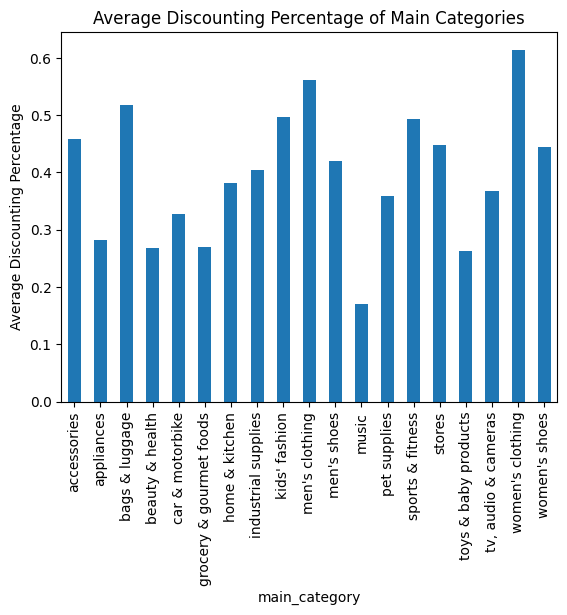

In [31]:
# Plot for average discount percentage by main category
products.groupby('main_category')['discounting_percent'].mean().plot(kind='bar')
plt.title('Average Discounting Percentage of Main Categories')
plt.ylabel('Average Discounting Percentage')
plt.show()

- Accessories: On average, accessories are discounted by around 45.89%.

- Appliances: Appliances tend to have lower discounts, averaging around 28.15%.

- Bags & Luggage: These items are typically discounted by about 51.74%.

- Beauty & Health: Products in this category are discounted on average by 26.83%.

- Car & Motorbike: These items see an average discount of approximately 32.75%.

- Grocery & Gourmet Foods: These items have discounts averaging around 27.05%.

- Home & Kitchen: Home and kitchen items are typically discounted by 38.11%.

- Industrial Supplies: These products have an average discount of 40.43%.

- Kids' Fashion: Items in the kids' fashion category have an average discount of approximately 49.73%.

- Men's Clothing: Men's clothes typically receive relatively high discounts around 56.16%.

- Men's Shoes: Men's shoes are discounted on average by around 42.00%.

- Music: Music items have the smallest average discounts at around 17.05%.

- Pet Supplies: Pet supplies are usually discounted around 35.95%.

- Sports & Fitness: Items in this category receive substantial discounts averaging around 49.34%.

- Stores: Not sure about the context here, but the average discount is approximately 44.76%.

- Toys & Baby Products: Toys and baby products see average discounts of around 26.28%.

- TV, Audio & Cameras: These items have an average discount of around 36.66%.

- Women's Clothing: Women's clothing receives the highest discounts among these categories with an average discount of 61.42%.

- Women's Shoes: Women's shoes have an average discount of approximately 44.37%.

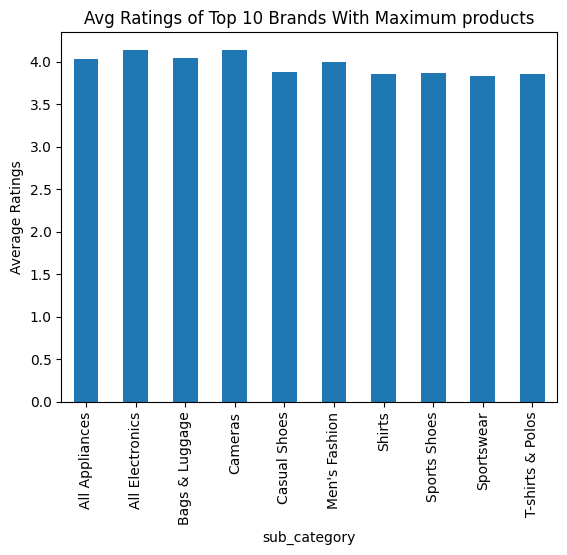

In [32]:
# Top 10 brands with highest number of ratings
top_brands = products['sub_category'].value_counts().index[:10]
products[products['sub_category'].isin(top_brands)].groupby('sub_category')['ratings'].mean().plot(kind='bar')
plt.title('Avg Ratings of Top 10 Brands With Maximum products')
plt.ylabel('Average Ratings')
plt.show()

The histogram indicates generally positive feedback across sub_categories, with all average ratings falling above 3.5. However, the absence of any sub-category with an average rating of 4.5 or higher suggests that there is room for improvement in the products.

### Analyze average ratings per country

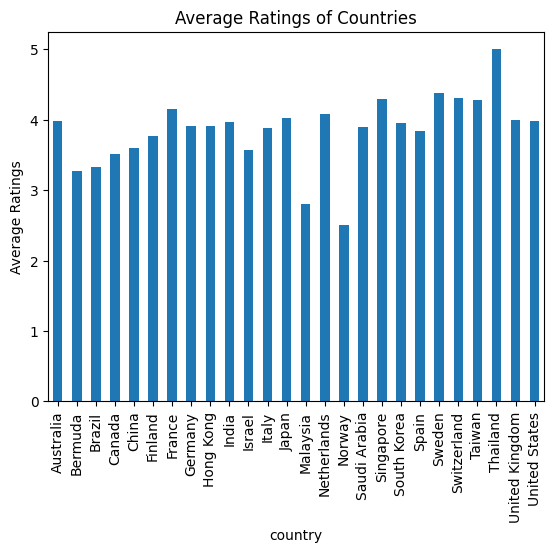

In [33]:
# Plot for avg rating per country
products.groupby('country')['ratings'].mean().plot(kind='bar')
plt.title('Average Ratings of Countries')
plt.ylabel('Average Ratings')
plt.show()

- Australia has an average rating of approximately 3.99, indicating that Australian consumers generally provide positive ratings.

- In Bermuda, the average rating is approximately 3.28, which is one of the lowest average ratings among the listed countries, suggesting more mixed or potentially negative reviews on average.

- Perhaps surprisingly, Brazil sees a very slightly higher average rating, of approximately 3.33.   

- Canada's average rating is higher yet, around 3.52, indicating more satisfactory reviews on average.

- China's average rating is about 3.60. 

- Finland's average product rating comes to approximately 3.77.

- France sees higher average ratings, with a mean of around 4.16.

- Similarly, Germany also has high average ratings at approximately 3.91.

- The average rating of products consumed in Hong Kong is about 3.92.

- In India, the average rating is around 3.97, showing high levels of customer satisfaction on average.

- Israel again represents a slightly less positive average rating, of approximately 3.56.

- The average rating from Italy is about 3.88.

- Japan presents a high average rating of 4.03.

- Malaysia's average rating of 2.80 is the lowest of the listed countries, indicating less satisfied consumers on average.

- Netherlands boasts a high average rating of approximately 4.08.

- Norway has the second-lowest average rating of 2.5.

- The average rating for Saudi Arabia is around 3.9.

- Singapore has an exceptionally high average rating of 4.3.

- South Korea's average rating is around 3.96.

- The average rating for Spain is approximately 3.85.

- Sweden tops the list with the highest average rating of 4.39.

- Switzerland also has a high average rating of about 4.31.

- Taiwan's average rating is around 4.28.

- Thailand has the perfect score of 5 as an average rating, indicating that all Thai consumers in the set gave the highest possible rating.

- The average rating in the United Kingdom is about 3.99.

- In the United States the average rating is around 3.98.

### Analyze the relationship between market cap and revenue

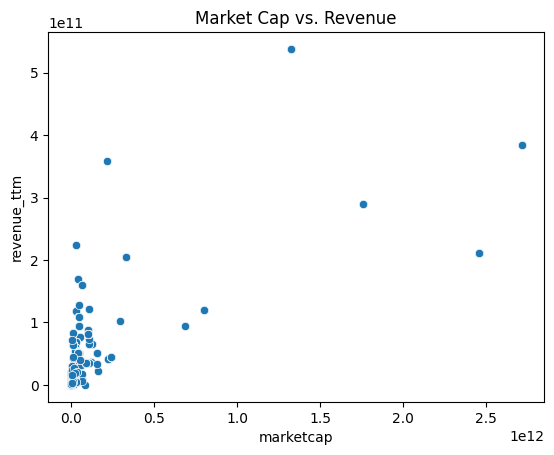

In [34]:
# Scatterplot to check the relationship between market cap and revenue
sns.scatterplot(data=products, x='marketcap', y='revenue_ttm')
plt.title('Market Cap vs. Revenue')
plt.show()

- A large number of values are centralized around (0.1, 0), (0.1, 1) and (0.1, 2): This may point out that several firms in the dataset have a market cap approaching zero while their revenues fall between $0.1 billion and $2 billion. These could potentially be small businesses or newly established companies that haven't reached a substantial market cap but have started generating some sales.
- The haphazard dispersion of other data points: The chaotic distribution of the rest of the points might suggest there is no distinct linear link between market cap and revenue for the remaining companies in the collection of data. Essentially, variations in market cap for these firms are not predictably aligned with changes in revenue.

### Analyze the distribution of the market capitalization of the companies

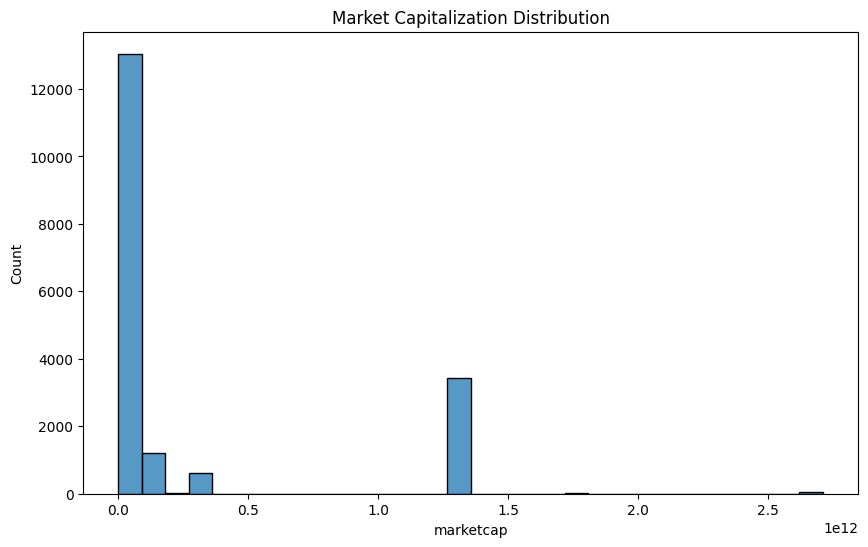

In [35]:
# Hist plot for market cap
plt.figure(figsize=(10,6))
sns.histplot(data=products, x='marketcap', bins=30)
plt.title('Market Capitalization Distribution')
plt.show()

- mean - The average market capitalization is approximately $2.88 x 10^11.

- min - The smallest market capitalization in the dataset is approximately $1.14 x 10^7.

- 25% - 25% of the data points have a market cap less than or equal to approximately $8.59 x 10^9.

- 50% - The median market cap (middle value) is approximately $1.63 x 10^10. Half of the data points are above this value, and half are below.

- 75% - 75% of the data points have a market cap less than or equal to approximately $1.60 x 10^11.

- max - The largest market capitalization in the dataset is approximately $2.71 x 10^12.

### Top 10 brands by revenue

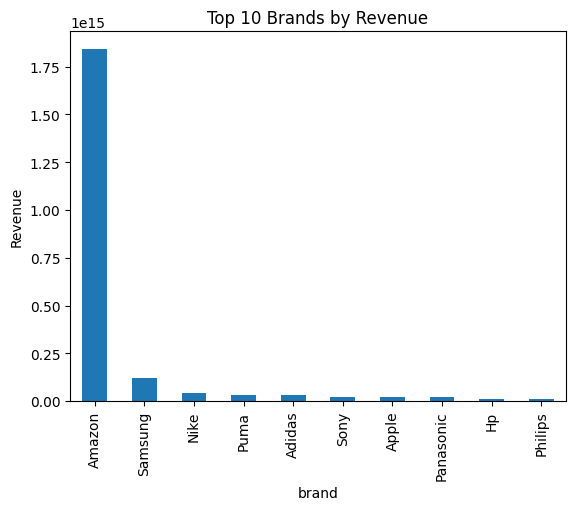

In [36]:
# Plot for top 10 brands by Revenue
top_brands = products.groupby('brand')['revenue_ttm'].sum().sort_values(ascending=False).head(10)
top_brands.plot(kind='bar')
plt.title('Top 10 Brands by Revenue')
plt.ylabel('Revenue')
plt.show()

The data indicates the total trailing twelve months (TTM) revenue of different brands. The values have been sorted in the descending order, meaning the brand with the highest revenue is listed first. Here are the top 10 brands along with their TTM revenue:


- Amazon: $1,842,269,504,000,000

- Samsung: $122,454,920,845,800

- Nike: $40,300,227,000,000

- Puma: $34,060,076,887,200

- Adidas: $31,210,220,141,064

- Sony: $23,923,720,675,440

- Apple: $23,419,913,000,000

- Panasonic: $20,494,303,365,620

- HP: $10,728,648,000,000

- Philips: $9,781,002,490,449

### Analyze the relationship between actual price and discounted price

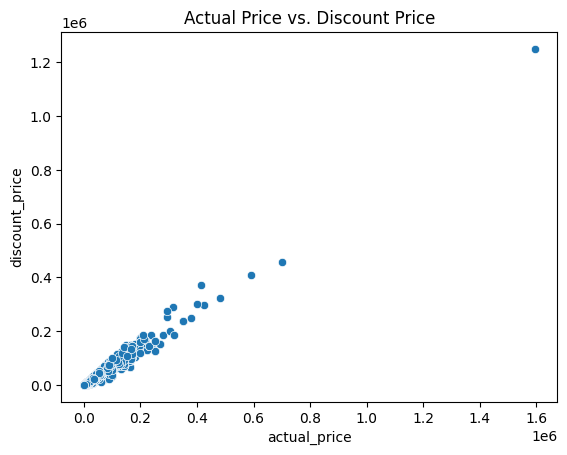

In [37]:
# Plot scatterplot to check the relationship between actual price and discount price
sns.scatterplot(data=products, x='actual_price', y='discount_price')
plt.title('Actual Price vs. Discount Price')
plt.show()

The scatter plot showing actual_price against discount_price exhibits a rising trend (slope), implying a strong positive relationship between both variables. As anticipated, the discount price often elevates with an increase in the actual product price, irrespective of the applied discount.

### Analyze the distribution of discount values

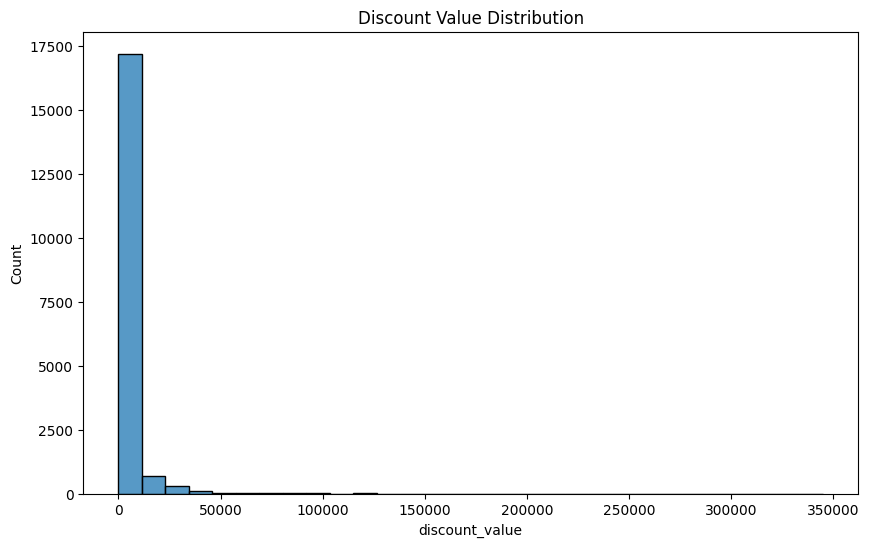

In [38]:
# Plot histogram for discount values
plt.figure(figsize=(10,6))
sns.histplot(data=products, x='discount_value', bins=30)
plt.title('Discount Value Distribution')
plt.show()

It suggests that most of the discounts are relatively small (likely close to the mode), while only a few are considerably larger. This could mean that while the business does occasionally offer large discounts, the most common practice is to provide customers with smaller discounts. 

### Analyze the average discount percent per brand (top 10 brands)

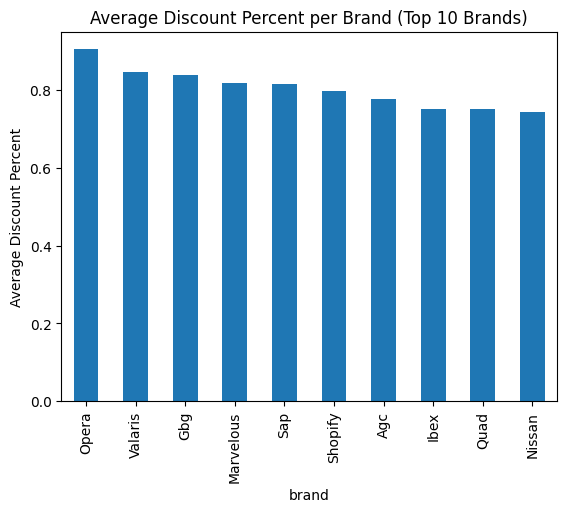

In [39]:
# Plot for ave discount percent per brand using groupby
products.groupby('brand')['discounting_percent'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Average Discount Percent per Brand (Top 10 Brands)')
plt.ylabel('Average Discount Percent')  
plt.show()

- The brand 'Opera' has the highest average discounting percent in the dataset giving about 90.41% discount.

- 'Valaris' is the brand with the second-highest average discounting percent, offering around an 84.68% discount.

- 'Gbg' comes in third with an average discounting percent of about 83.75%.

- 'Nissan,' has the tenth highest average discounting percentage of approximately 74.25%.

Overall, this analysis could help the user understand which brands offer more significant discounts on average in the dataset.

### Analyze the distribution of discount percent

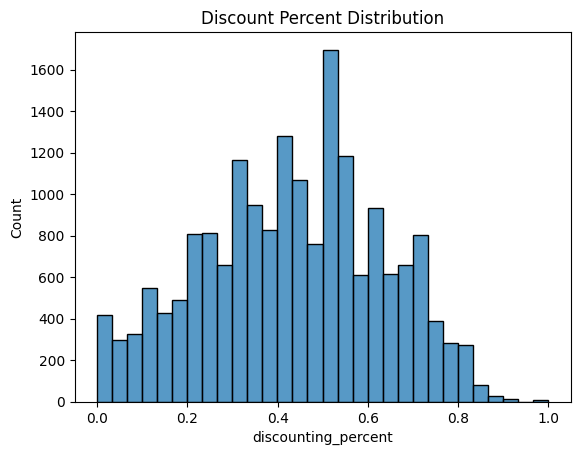

In [40]:
# Analyzing the distribution of discounting percent
sns.histplot(data=products, x='discounting_percent', bins=30)
plt.title('Discount Percent Distribution')
plt.show()

- Most of the discounts offered are around the mean (average) value. This is because in a normal distribution, the mean, median and mode are the same. Therefore, most of the data is clustered around the central value.

- Specific predictions can be made related to the percent of discounts. For example, roughly 68% of the discounts should fall within one standard deviation of the mean, around 95% within two standard deviations, and about 99.7% fall within three standard deviations.

- Extreme discount values, both high and low, are rare. These are the outliers and fall in the tails of the distribution.

## 3. Diagnostic Analysis


In [41]:
# Covert the actual price, discount price and discount value columns from Rs to USD 
exchange_rate = 0.012
products['actual_price'] = products['actual_price'] * exchange_rate
products['discount_price'] = products['discount_price'] * exchange_rate
products['discount_value'] = products['discount_value'] * exchange_rate
products.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent,brand,marketcap,country,revenue_ttm
0,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630.0,413.880,813.48,399.600,0.491223,Carrier,40331792384,United States,21821000000
1,Carrier 1 Ton 3 Star AI Flexicool Inverter Spl...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51sTXvsanQ...,https://www.amazon.in/Carrier-Flexicool-Invert...,4.1,674.0,371.880,698.28,326.400,0.467434,Carrier,40331792384,United States,21821000000
2,Carrier 1.5 Ton 5 Star AI Flexicool Inverter S...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/61JtwWcAco...,https://www.amazon.in/Carrier-Flexicool-Conver...,4.0,568.0,503.988,941.88,437.892,0.464913,Carrier,40331792384,United States,21821000000
3,Carrier 1.5 Ton 3 Star Fixed Speed Window AC( ...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/717wB+IneG...,https://www.amazon.in/Carrier-Window-Copper-Di...,4.3,201.0,371.880,541.08,169.200,0.312708,Carrier,40331792384,United States,21821000000
4,Carrier 2 Ton 5 Star AI Flexicool Inverter Spl...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/61JtwWcAco...,https://www.amazon.in/Carrier-Flexicool-Conver...,3.9,69.0,635.880,1100.28,464.400,0.422074,Carrier,40331792384,United States,21821000000


### Do pricing strategies differ for products for different genders?

In [42]:
# Define gender categories for filtering products
gender_cat = ['men\'s shoes', 'women\'s shoes', 'men\'s clothing', 'women\'s clothing']

# Filter products based on gender categories and store them
products_gender = products[products['main_category'].isin(gender_cat)]
products_gender['main_category'].value_counts()

main_category
men's shoes         4350
men's clothing      2124
women's clothing    1184
women's shoes        261
Name: count, dtype: int64

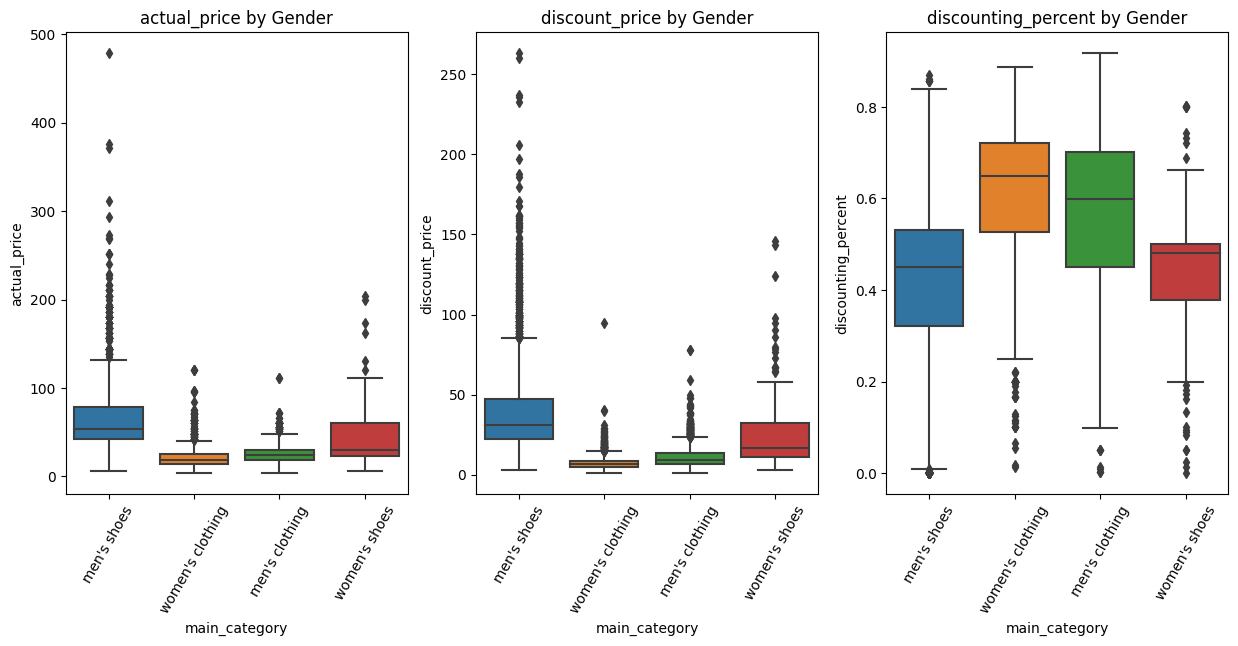

In [43]:
# List of pricing variables to visualize
pricing_vars = ['actual_price', 'discount_price', 'discounting_percent']
plt.figure(figsize=(15, 6))
# Iterate over the pricing variables
for i in range(3):
    plt.subplot(1, 3, i + 1)
    # Create a boxplot for the current pricing variable ('actual_price', 'discount_price', 'discounting_percent')
    # grouped by 'main_category' and using data from the 'products_gender' DataFrame
    sns.boxplot(x='main_category', 
                y=pricing_vars[i], 
                data=products_gender).set_title(f'{pricing_vars[i]} by Gender')
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=60)
# Display the subplots
plt.show()


Text(0.5, 1.0, 'Distribution of Actual Price by Gender for Clothing')

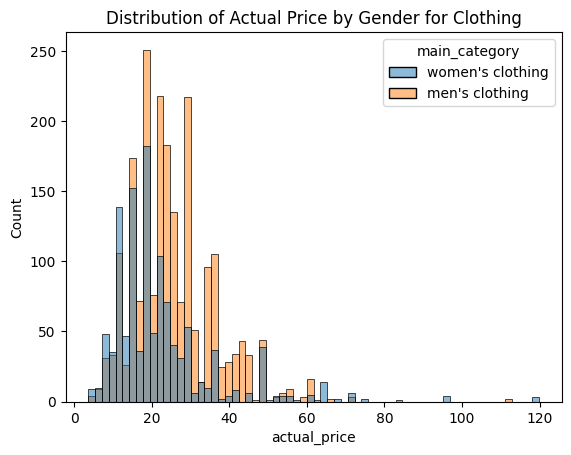

In [44]:
# Filter the 'products_gender' to include only rows where 'main_category' contains the string "clothing"
clothing = products_gender[products_gender['main_category'].str.contains("clothing")]
sns.histplot(data=clothing, 
             x='actual_price', 
             hue='main_category').set_title('Distribution of Actual Price by Gender for Clothing')

Text(0.5, 1.0, 'Distribution of Actual Price by Gender for Shoes')

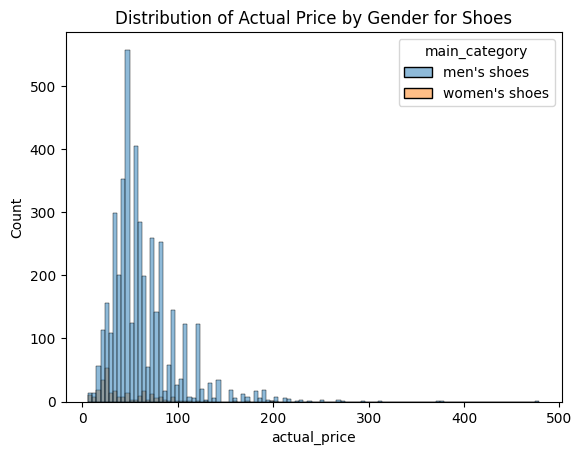

In [45]:
# # Filter the 'products_gender' to include only rows where 'main_category' contains the string "shoes"
shoes = products_gender[products_gender['main_category'].str.contains("shoes")]
sns.histplot(data=shoes, 
             x='actual_price', 
             hue='main_category').set_title('Distribution of Actual Price by Gender for Shoes')

In [46]:
# OLS summary
m_clothing = ols('actual_price ~ C(main_category)', data=clothing).fit()
m_clothing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           actual_price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     55.38
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           1.26e-13
Time:                        00:22:36   Log-Likelihood:                -12883.
No. Observations:                3308   AIC:                         2.577e+04
Df Residuals:                    3306   BIC:                         2.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               25.4044      0.258     98.453      0.000      24.898      25.910
C(main_category)[T.women's clothing]    -3.2096      0.431     -7.442      0.000      -4.055      -2.364
==============================================================================
Omnibus:                     1549.394   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12762.608
Skew:                           2.048   Prob(JB):                         0.00
Kurtosis:                      11.708   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value 1.26e-13 is below the critical value 0.05, so we can reject the null hypothesis in favor of the alternative hypothesis and conclude that there is a statistically significant difference in `actual_price` for clothing of different genders.

In [47]:
# OLS summary
m_shoes = ols('actual_price ~ C(main_category)', data=shoes).fit()
m_shoes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           actual_price   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     85.64
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           3.22e-20
Time:                        00:22:36   Log-Likelihood:                -22926.
No. Observations:                4611   AIC:                         4.586e+04
Df Residuals:                    4609   BIC:                         4.587e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            63.5383      0.530    119.990      0.000      62.500      64.576
C(main_category)[T.women's shoes]   -20.5974      2.226     -9.254      0.000     -24.961     -16.234
==============================================================================
Omnibus:                     2474.120   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28873.982
Skew:                           2.312   Prob(JB):                         0.00
Kurtosis:                      14.353   Cond. No.                         4.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value 3.22e-20 is below the critical value 0.05, so we can reject the null hypothesis in favor of the alternative hypothesis and conclude that there is a statistically significant difference in `actual_price` for shoes of different genders.

### Is there a relationship between the size of a brand and its pricing?

Text(0.5, 1.0, 'Correlation Matrix of Pricing and Financial Variables')

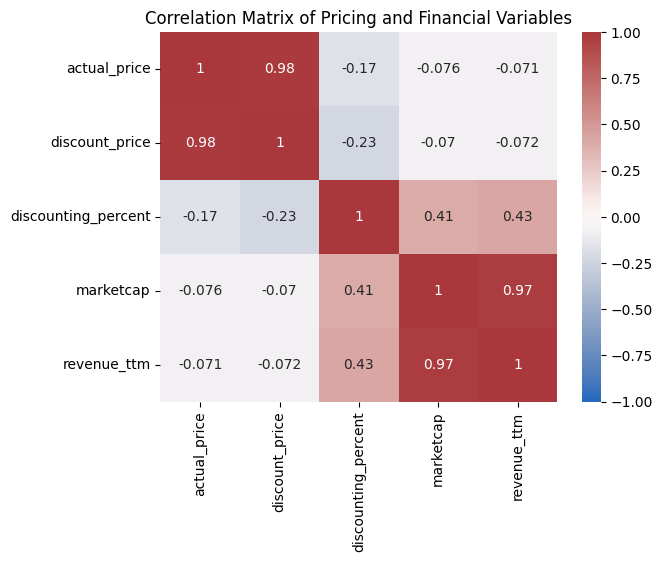

In [48]:
# Plot heatmap for correlation matrix
sns.heatmap(products[['actual_price', 'discount_price', 'discounting_percent', 'marketcap', 'revenue_ttm']].corr(), 
            annot=True, cmap='vlag', vmin=-1, vmax=1).set_title('Correlation Matrix of Pricing and Financial Variables')

The heatmap indicates that there is a slight positive relationship between `discounting_percent` and `revenue_ttm`, with a correlation of 0.43. While there is also a slight positive relationship between `discounting_percent` and `markecap`, with a correlation of 0.41, since `marketcap` and `revenue_ttm` are highly correlated with a correlation of 0.97, we will not consider `marketcap` and mainly focus on `revenue_ttm` in the following analysis.

Text(0.5, 1.0, 'Revenue vs Discounting Percent')

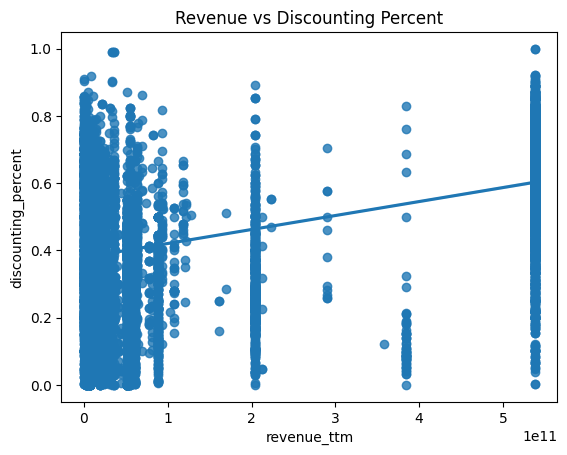

In [49]:
# Regression plot 
sns.regplot(x='revenue_ttm', y='discounting_percent', data=products).set_title('Revenue vs Discounting Percent')

The regression plot also shows that there is a slight positive relationship between `discounting_percent` and `revenue_ttm`.

In [50]:
# OLS summary
m_revenue_discount = ols('discounting_percent ~ revenue_ttm', data=products).fit()
m_revenue_discount.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     discounting_percent   R-squared:                       0.182
Model:                             OLS   Adj. R-squared:                  0.182
Method:                  Least Squares   F-statistic:                     4079.
Date:                 Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                         00:22:38   Log-Likelihood:                 5454.8
No. Observations:                18390   AIC:                        -1.091e+04
Df Residuals:                    18388   BIC:                        -1.089e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3790      0.002    245.264      0.000       0.376       0.382
revenue_ttm  4.156e-13   6.51e-15     63.865      0.000    4.03e-13    4.28e-13
==============================================================================
Omnibus:                      373.689   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.372
Skew:                          -0.241   Prob(JB):                     1.33e-66
Kurtosis:                       2.595   Cond. No.                     2.77e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-value 0.00 is below the critical value 0.05, so we can reject the null hypothesis in favor of the alternative hypothesis and conclude that there is a statistically significant relationship between `discounting_percent` and `revenue_ttm`.

### Are there differences for the discount strategy among countries?

Text(0.5, 1.0, 'Discounting Percent by Country')

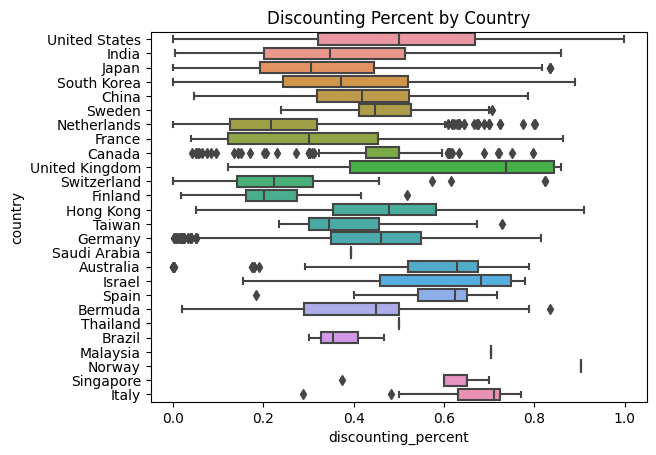

In [51]:
# Create a boxplot for discounting percent grouped by country
sns.boxplot(x='discounting_percent', y='country', data=products).set_title('Discounting Percent by Country')

(0.0, 3000.0)

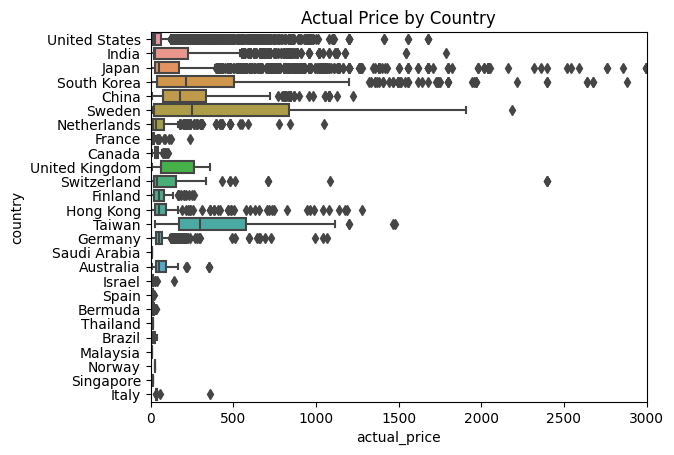

In [52]:
# Create a boxplot for actual price grouped by country
sns.boxplot(x='actual_price', y='country', data=products).set_title('Actual Price by Country')
plt.xlim(0, 3000)

The boxplot above shows that there are differences in `discounting_percent` and `actual_price` by country. Also, the boxplot of Malaysia and of Norway are concentrated in one dot, so we will investigate it through digging into the original data.

In [53]:
# Check for Norway
products[products['country'] == 'Norway']

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent,brand,marketcap,country,revenue_ttm
18198,OPERA SPARK INDIA:- Afghani Oxidised Silver Je...,accessories,Fashion & Silver Jewellery,https://m.media-amazon.com/images/I/61rkOqe1oe...,https://www.amazon.in/OPERA-SPARK-INDIA-Oxidis...,2.5,2.0,2.532,26.4,23.868,0.904091,Opera,985555712,Norway,362804000


In [54]:
# Check for Malaysia
products[products['country'] == 'Malaysia']

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent,brand,marketcap,country,revenue_ttm
18187,sunway M3 Silicone LED Digital Black Men's Wom...,accessories,Fashion & Silver Jewellery,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/sunway-Silicone-Digital-...,2.8,332.0,1.776,5.988,4.212,0.703407,Sunway,1973697572,Malaysia,1222637219
18188,sunway M3 Silicone LED Digital Black Men's Wom...,stores,Men's Fashion,https://m.media-amazon.com/images/W/IMAGERENDE...,https://www.amazon.in/sunway-Silicone-Digital-...,2.8,332.0,1.776,5.988,4.212,0.703407,Sunway,1973697572,Malaysia,1222637219


There is only two products for Malaysia and one product for Norway, so we will remove these products in the hypothesis testing to avoid data bias.

In [55]:
# Data preparation for choropleth map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [56]:
# Add country country code to products dataset for mapping
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

iso_map = {country: do_fuzzy_search(country) for country in products['country'].unique()}
products['country_code'] = products['country'].map(iso_map)
products.head()
# Reference: https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent,brand,marketcap,country,revenue_ttm,country_code
0,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630.0,413.880,813.48,399.600,0.491223,Carrier,40331792384,United States,21821000000,USA
1,Carrier 1 Ton 3 Star AI Flexicool Inverter Spl...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51sTXvsanQ...,https://www.amazon.in/Carrier-Flexicool-Invert...,4.1,674.0,371.880,698.28,326.400,0.467434,Carrier,40331792384,United States,21821000000,USA
2,Carrier 1.5 Ton 5 Star AI Flexicool Inverter S...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/61JtwWcAco...,https://www.amazon.in/Carrier-Flexicool-Conver...,4.0,568.0,503.988,941.88,437.892,0.464913,Carrier,40331792384,United States,21821000000,USA
3,Carrier 1.5 Ton 3 Star Fixed Speed Window AC( ...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/717wB+IneG...,https://www.amazon.in/Carrier-Window-Copper-Di...,4.3,201.0,371.880,541.08,169.200,0.312708,Carrier,40331792384,United States,21821000000,USA
4,Carrier 2 Ton 5 Star AI Flexicool Inverter Spl...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/61JtwWcAco...,https://www.amazon.in/Carrier-Flexicool-Conver...,3.9,69.0,635.880,1100.28,464.400,0.422074,Carrier,40331792384,United States,21821000000,USA


In [57]:
# Group by country code and calculate median discounting percent and actual price
discount_country = products.groupby('country_code')[['discounting_percent', 'actual_price']].median()
discount_country = discount_country.reset_index()
discount_country

,country_code,discounting_percent,actual_price
0,AUS,0.628650,47.880
1,BMU,0.450281,16.788
2,BRA,0.353149,20.388
3,CAN,0.500000,34.680
4,CHE,0.222778,41.334
5,CHN,0.418530,180.000
6,DEU,0.460413,47.988
7,ESP,0.625391,13.200
8,FIN,0.200118,51.588
9,FRA,0.300351,9.282


In [58]:
# Merge products and world dataset for Choropleth map
products_geo = pd.merge(world, discount_country, left_on='iso_a3', right_on='country_code', how='left')
products_geo['discounting_percent'] = products_geo['discounting_percent'].fillna(0)
products_geo['actual_price'] = products_geo['actual_price'].fillna(0)

Text(0.5, 1.0, 'Median of Discounting Percent by Country')

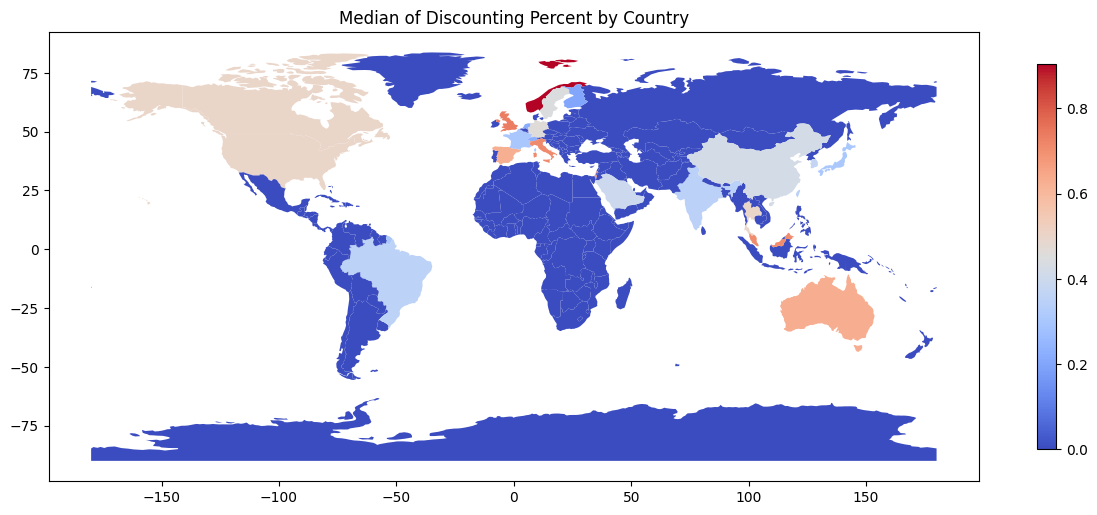

In [59]:
# Plot Choropleth map for median discounting percent by country
products_geo.plot(column='discounting_percent', 
                  cmap='coolwarm', 
                  legend=True, 
                  legend_kwds={"shrink": 0.5}, 
                  figsize=(15, 10))
plt.title('Median of Discounting Percent by Country')

Text(0.5, 1.0, 'Median of Actual Price by Country')

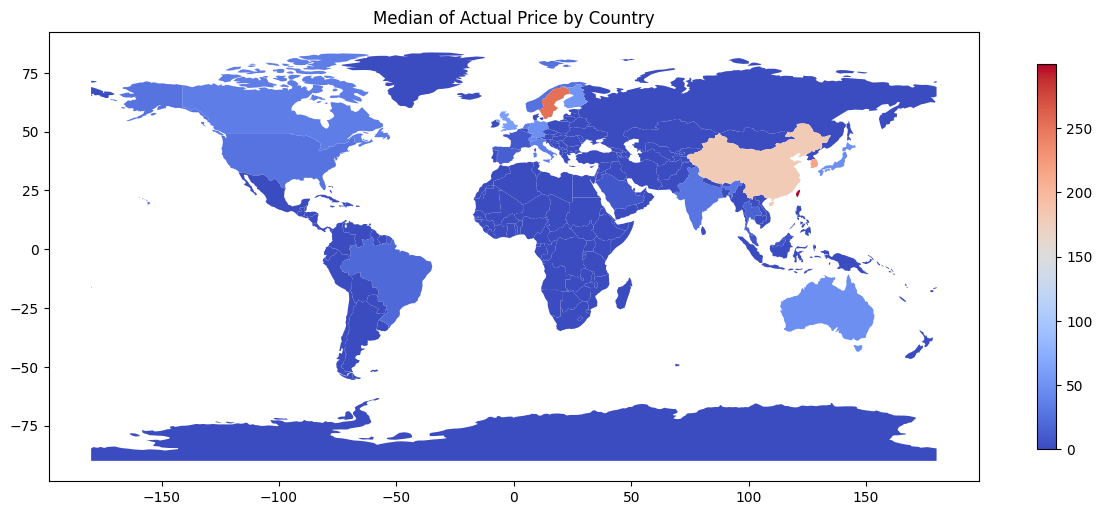

In [60]:
# Plot Choropleth map for median actual price by country
products_geo.plot(column='actual_price', 
                  cmap='coolwarm', 
                  legend=True, 
                  legend_kwds={"shrink": 0.5}, 
                  figsize=(15, 10))
plt.title('Median of Actual Price by Country')

In [61]:
# Drop products with brands in Norway and Malaysia from products dataset
products_xNOR_xMYS = products.drop([18187, 18188, 18198])

In [62]:
# Conduct hypothesis test for discounting percent by country
m_discount_country = ols('discounting_percent ~ C(country)', data=products_xNOR_xMYS).fit()
m_discount_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     discounting_percent   R-squared:                       0.106
Model:                             OLS   Adj. R-squared:                  0.105
Method:                  Least Squares   F-statistic:                     94.89
Date:                 Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                         00:22:41   Log-Likelihood:                 4647.8
No. Observations:                18387   AIC:                            -9248.
Df Residuals:                    18363   BIC:                            -9060.
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.5594      0.021     27.266      0.000       0.519       0.600
C(country)[T.Bermuda]           -0.1490      0.031     -4.731      0.000      -0.211      -0.087
C(country)[T.Brazil]            -0.1859      0.110     -1.683      0.092      -0.402       0.031
C(country)[T.Canada]            -0.0986      0.023     -4.301      0.000      -0.143      -0.054
C(country)[T.China]             -0.1386      0.022     -6.288      0.000      -0.182      -0.095
C(country)[T.Finland]           -0.3423      0.032    -10.716      0.000      -0.405      -0.280
C(country)[T.France]            -0.2393      0.032     -7.455      0.000      -0.302      -0.176
C(country)[T.Germany]           -0.1130      0.021     -5.463      0.000      -0.154      -0.072
C(country)[T.Hong Kong]         -0.1050      0.023     -4.514      0.000      -0.151      -0.059
C(country)[T.India]             -0.2069      0.021     -9.710      0.000      -0.249      -0.165
C(country)[T.Israel]             0.0197      0.040      0.492      0.623      -0.059       0.098
C(country)[T.Italy]              0.0875      0.050      1.749      0.080      -0.011       0.185
C(country)[T.Japan]             -0.2239      0.021    -10.715      0.000      -0.265      -0.183
C(country)[T.Netherlands]       -0.3125      0.022    -14.134      0.000      -0.356      -0.269
C(country)[T.Saudi Arabia]      -0.1654      0.189     -0.875      0.382      -0.536       0.205
C(country)[T.Singapore]          0.0360      0.087      0.416      0.678      -0.134       0.206
C(country)[T.South Korea]       -0.1774      0.021     -8.296      0.000      -0.219      -0.136
C(country)[T.Spain]              0.0009      0.060      0.016      0.988      -0.117       0.119
C(country)[T.Sweden]            -0.0899      0.036     -2.487      0.013      -0.161      -0.019
C(country)[T.Switzerland]       -0.3083      0.028    -11.126      0.000      -0.363      -0.254
C(country)[T.Taiwan]            -0.1696      0.029     -5.811      0.000      -0.227      -0.112
C(country)[T.Thailand]          -0.0594      0.135     -0.442      0.659      -0.323       0.204
C(country)[T.United Kingdom]     0.0761      0.045      1.690      0.091      -0.012       0.164
C(country)[T.United States]     -0.0779      0.021     -3.775      0.000      -0.118      -0.037
==============================================================================
Omnibus:                      201.839   Durbin-Watson:                   0.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.260
Skew:                          -0.203   Prob(JB):                     9.74e-41
Kurtosis:                       2.726   Cond. No.                         153.
==========================================================

The p-value 0.00 is below the critical value 0.05, so we can reject the null hypothesis in favor of the alternative hypothesis and conclude that there is a statistically significant difference in `discounting_percent` for brands from different countries. In addition, the coefficients of Finland (-0.3423) and Switzerland (-0.3083) indicate that brands of these two countries tend to have much smaller discounting_percent.

In [63]:
# Conduct hypothesis test for actual price by country
m_price_country = ols('actual_price ~ C(country)', data=products_xNOR_xMYS).fit()
m_price_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           actual_price   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     89.27
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:22:41   Log-Likelihood:            -1.3048e+05
No. Observations:               18387   AIC:                         2.610e+05
Df Residuals:                   18363   BIC:                         2.612e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       75.1722     31.906      2.356      0.018      12.633     137.712
C(country)[T.Bermuda]          -57.2402     48.962     -1.169      0.242    -153.210      38.730
C(country)[T.Brazil]           -54.3842    171.821     -0.317      0.752    -391.170     282.401
C(country)[T.Canada]           -40.1630     35.641     -1.127      0.260    -110.022      29.696
C(country)[T.China]            184.1450     34.281      5.372      0.000     116.950     251.340
C(country)[T.Finland]           -4.2051     49.673     -0.085      0.933    -101.569      93.158
C(country)[T.France]           -52.7306     49.924     -1.056      0.291    -150.586      45.125
C(country)[T.Germany]          -20.3584     32.172     -0.633      0.527     -83.419      42.702
C(country)[T.Hong Kong]         48.1855     36.165      1.332      0.183     -22.701     119.072
C(country)[T.India]            102.9476     33.126      3.108      0.002      38.017     167.878
C(country)[T.Israel]           -58.5434     62.197     -0.941      0.347    -180.455      63.368
C(country)[T.Italy]            -19.7019     77.770     -0.253      0.800    -172.139     132.735
C(country)[T.Japan]            162.7484     32.495      5.008      0.000      99.055     226.442
C(country)[T.Netherlands]        0.4733     34.382      0.014      0.989     -66.919      67.866
C(country)[T.Saudi Arabia]     -67.9842    294.162     -0.231      0.817    -644.570     508.601
C(country)[T.Singapore]        -63.1842    134.613     -0.469      0.639    -327.039     200.670
C(country)[T.South Korea]      319.1058     33.261      9.594      0.000     253.912     384.300
C(country)[T.Spain]            -62.1981     93.765     -0.663      0.507    -245.987     121.591
C(country)[T.Sweden]           457.9725     56.177      8.152      0.000     347.860     568.085
C(country)[T.Switzerland]      101.1900     43.086      2.349      0.019      16.738     185.642
C(country)[T.Taiwan]           341.0491     45.397      7.513      0.000     252.067     430.031
C(country)[T.Thailand]         -59.5962    209.224     -0.285      0.776    -469.695     350.502
C(country)[T.United Kingdom]    53.6767     70.036      0.766      0.443     -83.600     190.953
C(country)[T.United States]     -3.4325     32.103     -0.107      0.915     -66.358      59.493
==============================================================================
Omnibus:                    40745.873   Durbin-Watson:                   0.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        776291395.700
Skew:                          19.987   Prob(JB):                         0.00
Kurtosis:                    1008.819   Cond. No.                         153.
=====================================================================

The p-value 0.00 is below the critical value 0.05, so we can reject the null hypothesis in favor of the alternative hypothesis and conclude that there is a statistically significant difference in `actual_price` for brands from different countries. In addition, the coefficients of Sweden (457.9725) and Taiwan (341.0491) indicate that brands of these two countries tend to have higher prices for their products.

## 4. Predictive Analysis

### Predicting Ratings

In [64]:
# Assuming 'sub_category', 'ratings', 'no_of_ratings', 'discount_value', 'brand' columns exist in the 'products' DataFrame
products_for_ratings = products[['sub_category', 'ratings', 'no_of_ratings', 'actual_price', 'discount_value', 'brand']].copy()
products_for_ratings.head()

,sub_category,ratings,no_of_ratings,actual_price,discount_value,brand
0,Air Conditioners,4.1,630.0,813.48,399.600,Carrier
1,Air Conditioners,4.1,674.0,698.28,326.400,Carrier
2,Air Conditioners,4.0,568.0,941.88,437.892,Carrier
3,Air Conditioners,4.3,201.0,541.08,169.200,Carrier
4,Air Conditioners,3.9,69.0,1100.28,464.400,Carrier


Removing Marketcap and Revenue of the company because of the understanding that a company may sell a diverse range of products, and assuming the revenue of the entire company for predicting ratings on a single product may not be a valid approach.

In [65]:
products_for_ratings.shape

(18390, 6)

In [66]:
# Check the unique sub_categories
print("total unique sub_categories are:", products_for_ratings['sub_category'].nunique())
print("---------------------------------")
print(products_for_ratings['sub_category'].value_counts())

total unique sub_categories are: 105
---------------------------------
sub_category
Casual Shoes             2171
Sports Shoes             1926
Men's Fashion            1191
All Electronics          1109
T-shirts & Polos         1017
                         ... 
Dog supplies                2
Rucksacks                   1
Fashion Sales & Deals       1
Travel Duffles              1
Kids' Watches               1
Name: count, Length: 105, dtype: int64


In [67]:
# Check the unique brands
print("total unique brands are:", products_for_ratings['brand'].nunique())
print("------------------------")
print(products_for_ratings['brand'].value_counts())

total unique brands are: 213
------------------------
brand
Puma          3640
Amazon        3424
Adidas        1332
Nike           783
United         621
              ... 
Avista           1
Shangri-la       1
Onex             1
Marvelous        1
Itt              1
Name: count, Length: 213, dtype: int64


In [68]:
# Print numerical statistics 
products_for_ratings.describe()

,ratings,no_of_ratings,actual_price,discount_value
count,18390.000000,18390.000000,18390.000000,18390.000000
mean,3.947227,2135.483904,119.227705,40.778386
std,0.649333,17377.744145,308.126338,96.857264
min,1.000000,1.000000,0.456000,0.000600
25%,3.700000,8.000000,21.588000,8.988000
50%,4.000000,54.000000,41.940000,17.532000
75%,4.300000,384.000000,82.800000,31.797000
max,5.000000,437652.000000,19138.800000,4138.920000


In [69]:
# Split the data into features (X) and target variable (y)
X = products_for_ratings.drop(columns=['ratings'])
y = products_for_ratings['ratings']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Target encode 'sub_category' and 'brand'
target_encoder = TargetEncoder()
X_train[['sub_category', 'brand']] = target_encoder.fit_transform(X_train[['sub_category', 'brand']], y_train)
X_test[['sub_category', 'brand']] = target_encoder.transform(X_test[['sub_category', 'brand']])


In [71]:
# Standardize 'no_of_ratings', 'actual_price', 'discount_value'
scaler = StandardScaler()
X_train[['no_of_ratings', 'actual_price', 'discount_value']] = scaler.fit_transform(X_train[
    ['no_of_ratings', 'actual_price', 'discount_value']])
X_test[['no_of_ratings', 'actual_price', 'discount_value']] = scaler.transform(X_test[
    ['no_of_ratings', 'actual_price', 'discount_value']])

- Total unique values in sub_category are 105 and in brands 213
There are 105 unique values in sub_category and 213 unique values in brand, stating that the dataset has a high cardinality. 

- Target encoding can be a good encoder when dealing with high-cardinality categorical variables. One-hot encoding in such cases could lead to a sparse dataset and may not be practical. Moreover, Target encoding is less prone to data leakage compared to other encoding methods because it is computed on the training set only.

In [72]:
X_train.head()

,sub_category,no_of_ratings,actual_price,discount_value,brand
14313,3.836515,-0.116892,-0.270009,-0.237693,3.882673
11890,3.868092,-0.100832,-0.219015,-0.121350,3.916055
7153,3.892675,-0.120115,-0.270009,-0.162691,3.803434
17205,3.966104,-0.119226,-0.371997,-0.412271,4.034588
15031,3.845194,-0.120560,-0.360230,-0.402416,3.657621


In [73]:
X_test.head()

,sub_category,no_of_ratings,actual_price,discount_value,brand
17886,4.115608,0.076391,-0.324926,-0.341877,4.209650
3189,3.897634,-0.119504,-0.313119,-0.295863,3.939227
11015,3.735047,-0.120560,-0.360230,-0.405872,3.916055
13607,3.990157,-0.097608,-0.289622,-0.287481,3.882673
11662,3.868092,-0.116170,-0.171944,-0.045068,3.916055


In [74]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation results
    print(f'{model_name} - Mean Squared Error: {mse}')
    print(f'{model_name} - R-squared: {r2}')
    print()

In [75]:
# Linear Regression
linear_model = LinearRegression()
train_evaluate_model(linear_model, X_train, y_train, X_test, y_test, 'Linear Regression')

Linear Regression - Mean Squared Error: 0.38319194085492425
Linear Regression - R-squared: 0.10354884389979746



In [76]:
# Support Vector Regression (SVR)
svr_model = SVR(kernel='rbf')
train_evaluate_model(svr_model, X_train, y_train, X_test, y_test, 'SVR')

SVR - Mean Squared Error: 0.38549168919615817
SVR - R-squared: 0.09816874103375317



In [77]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
train_evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'Random Forest Regression')

Random Forest Regression - Mean Squared Error: 0.3507331307801326
Random Forest Regression - R-squared: 0.17948399470768006



In [78]:
# XGBoost Regressor
xgb_model = XGBRegressor()
train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test, 'XGBoost Regressor')

XGBoost Regressor - Mean Squared Error: 0.36197335255064556
XGBoost Regressor - R-squared: 0.15318826996326562



Linear Regression, SVR, Random Forest Regression and XGBoost, all models underoperformed while predicting the ratings using features such as Brand, Actual_price, Discount_value and no_of_ratings.

In [79]:
# create a new dataframe with name, sub_category, brand, ratings, actual_price, discount_value, no_of_ratings
products_new = products[['name', 'sub_category', 'brand', 'ratings', 'actual_price', 'discount_value', 'no_of_ratings']].copy()
products_new.head()

,name,sub_category,brand,ratings,actual_price,discount_value,no_of_ratings
0,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,Air Conditioners,Carrier,4.1,813.48,399.600,630.0
1,Carrier 1 Ton 3 Star AI Flexicool Inverter Spl...,Air Conditioners,Carrier,4.1,698.28,326.400,674.0
2,Carrier 1.5 Ton 5 Star AI Flexicool Inverter S...,Air Conditioners,Carrier,4.0,941.88,437.892,568.0
3,Carrier 1.5 Ton 3 Star Fixed Speed Window AC( ...,Air Conditioners,Carrier,4.3,541.08,169.200,201.0
4,Carrier 2 Ton 5 Star AI Flexicool Inverter Spl...,Air Conditioners,Carrier,3.9,1100.28,464.400,69.0


In [80]:
# print the first 10 rows of name if the sub_category is casual shoes
products_new[products_new['sub_category'] == 'Casual Shoes']['name'][:10]

2416    Amazon Brand - Symbol Men's Copper Grey Boots-...
2417               Amazon Brand - Symbol Mens Dax Sneaker
2418             Amazon Brand - Symbol Men's Penny Loafer
2419              Amazon Brand - Symbol Mens Burke Loafer
2420     Amazon Brand - House & Shields Men's Loafer Flat
2421    Amazon Brand - House & Shields Mens Hs-aw21-75...
2422               Amazon Brand - Symbol Mens Loafer Flat
2423    Amazon Brand - House & Shields Mens Stuart Moc...
2424                   Amazon Brand - Symbol Mens Sneaker
2425                  Amazon Brand - Symbol Mens Sneakers
Name: name, dtype: object

In [81]:
products_new[products_new['sub_category'] == 'Casual Shoes']['name'].iloc[5]

'Amazon Brand - House & Shields Mens Hs-aw21-75 Loafer Flat'

In [82]:
products_new[products_new['sub_category'] == 'Sports Shoes']['name'][:10]

4542           Amazon Brand - Symactive Mens Walking Shoe
4543    Amazon Brand - Symactive Mens Fanatic Running ...
4544    Amazon Brand - Symactive Mens Miranda Walking ...
4545    Amazon Brand - Symactive Mens Ricochet Running...
4546     Amazon Brand - Symactive Mens Delta Running Shoe
4547     Amazon Brand - Symactive Mens Matic Running Shoe
4548          Amazon Brand - Symactive Men's Walking Shoe
4549    Amazon Brand - Symactive Mens Prism Running Shoes
4550      Amazon Brand - Symactive Mens Orka Running Shoe
4551    Amazon Brand - Symactive Men's Walking Shoes (...
Name: name, dtype: object

In [83]:
products_new[products_new['sub_category'] == "Men's Fashion"]['name'][:10]

4055       Amazon Brand - Symbol Men's Regular Polo Shirt
4056    Amazon Brand - Symbol Mens Men Formal Shoes Shoes
4057      Amazon Brand - Symbol Men's Regular Fit T-Shirt
4058     Amazon Brand - Inkast Denim Co. Men Casual Shirt
4059    Amazon Brand - Inkast Denim Co. Men's Slim Str...
4060      Amazon Brand - Symbol Men's Regular Fit T-Shirt
4061      Amazon Brand - Symbol Men's Regular Track Pants
4062    Amazon Brand - Symbol Men's Cotton Regular Box...
4063    Amazon Brand - Symbol Men's Cotton Regular Box...
4064    Amazon Brand - Symbol Men's Slim Fit Formal Tr...
Name: name, dtype: object

The subcategories, namely Casual Shoes, Sports Shoes, and Men's Fashion, have the highest number of entries. Upon closer examination, it becomes evident that the last word in each of these subcategories corresponds to either a specific type of shoe or a category within Men's Fashion, with a few occurrences of the former being observed.

In [84]:
# create a new column with the last word of name
products_new['shoe_category'] = products_new['name'].str.split().str[-1]
products_new.head(10)

,name,sub_category,brand,ratings,actual_price,discount_value,no_of_ratings,shoe_category
0,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,Air Conditioners,Carrier,4.1,813.48,399.600,630.0,"Model,R32,White)"
1,Carrier 1 Ton 3 Star AI Flexicool Inverter Spl...,Air Conditioners,Carrier,4.1,698.28,326.400,674.0,F...
2,Carrier 1.5 Ton 5 Star AI Flexicool Inverter S...,Air Conditioners,Carrier,4.0,941.88,437.892,568.0,2.5...
3,Carrier 1.5 Ton 3 Star Fixed Speed Window AC( ...,Air Conditioners,Carrier,4.3,541.08,169.200,201.0,Contro...
4,Carrier 2 Ton 5 Star AI Flexicool Inverter Spl...,Air Conditioners,Carrier,3.9,1100.28,464.400,69.0,F...
5,Carrier 2 Ton 3 Star AI Flexicool Inverter Spl...,Air Conditioners,Carrier,4.0,970.68,382.800,66.0,F...
6,Carrier 1 Ton 3 Star Fixed Speed Split AC (Cop...,Air Conditioners,Carrier,3.9,655.08,271.200,134.0,Filtrat...
7,Carrier 1.5 Ton 5 Star Hybridjet Inverter Spli...,Air Conditioners,Carrier,4.6,958.68,412.800,3.0,Guar...
8,Carrier 1.5 Ton 5 Star Smart AI Flexicool Hybr...,Air Conditioners,Carrier,5.0,958.68,406.800,1.0,G...
9,Carrier 1 Ton 3 Star Fixed Speed Window AC(Cop...,Air Conditioners,Carrier,4.0,469.08,121.200,1.0,2...


In [85]:
products_new[products_new['sub_category'] == 'Casual Shoes']['shoe_category'][:10]

2416    (AZ-OM-71A)
2417        Sneaker
2418         Loafer
2419         Loafer
2420           Flat
2421           Flat
2422           Flat
2423      Moccasins
2424        Sneaker
2425       Sneakers
Name: shoe_category, dtype: object

In [86]:
products_new[products_new['sub_category'] == "Men's Fashion"]['shoe_category'][:10]

4055       Shirt
4056       Shoes
4057     T-Shirt
4058       Shirt
4059       Jeans
4060     T-Shirt
4061       Pants
4062      Shorts
4063       Vary)
4064    Trousers
Name: shoe_category, dtype: object

In [87]:
products_new['shoe_category'].value_counts()

shoe_category
Shoe       1479
Shoes      1189
Sneaker    1007
Shirt       917
T-Shirt     911
           ... 
Tshirts       1
63.8g         1
Gree...       1
(115ml)       1
1pc           1
Name: count, Length: 3733, dtype: int64

In [88]:
# convert the last_word to lower case
products_new['shoe_category'] = products_new['shoe_category'].str.lower()

In [89]:
keywords = ['sneaker', 'sneakers', 'loafer', 'flat', 'shoe', 'shoes', 'sandal', 'slipper', 'flip-flops']
# Keep only the rows where 'last_word' is in the specified keywords
filtered_products = products_new[products_new['shoe_category'].isin(keywords)]
products_new = products_new[products_new['shoe_category'].isin(keywords)]
products_new = products_new[products_new['shoe_category'].isin(keywords)].copy()

In [90]:
products_new[products_new['sub_category'] == "Men's Fashion"]

,name,sub_category,brand,ratings,actual_price,discount_value,no_of_ratings,shoe_category
4056,Amazon Brand - Symbol Mens Men Formal Shoes Shoes,Men's Fashion,Amazon,3.8,20.388,14.16000,3744.0,shoes
4069,Amazon Brand - Symbol Mens Flip-Flops,Men's Fashion,Amazon,4.0,10.788,8.05620,2004.0,flip-flops
4077,Amazon Brand - Symbol mens Evergreen Flip-Flops,Men's Fashion,Amazon,3.8,9.588,6.85620,532.0,flip-flops
4080,Amazon Brand - Symactive Mens Walking Shoe,Men's Fashion,Amazon,4.1,20.388,14.18988,732.0,shoe
4105,Amazon Brand - Symbol Mens Santiago Formal Shoes,Men's Fashion,Amazon,3.9,15.588,9.36000,257.0,shoes
...,...,...,...,...,...,...,...,...
16971,crocs unisex-adult Classic Slipper,Men's Fashion,Crocs,4.2,23.940,11.97600,8636.0,slipper
16990,crocs Unisex-Adult Classmarbleslid Slipper,Men's Fashion,Crocs,4.2,23.940,11.36400,10834.0,slipper
16991,crocs Unisex-Adult Classic Sandal,Men's Fashion,Crocs,4.2,35.940,17.97600,13275.0,sandal
16992,crocs Unisex-Adult Flip-Flops,Men's Fashion,Crocs,4.1,27.540,15.15600,8333.0,flip-flops


In [91]:
products_new.shape

(4361, 8)

In [92]:
products_new = products_new.drop(columns=['name'])

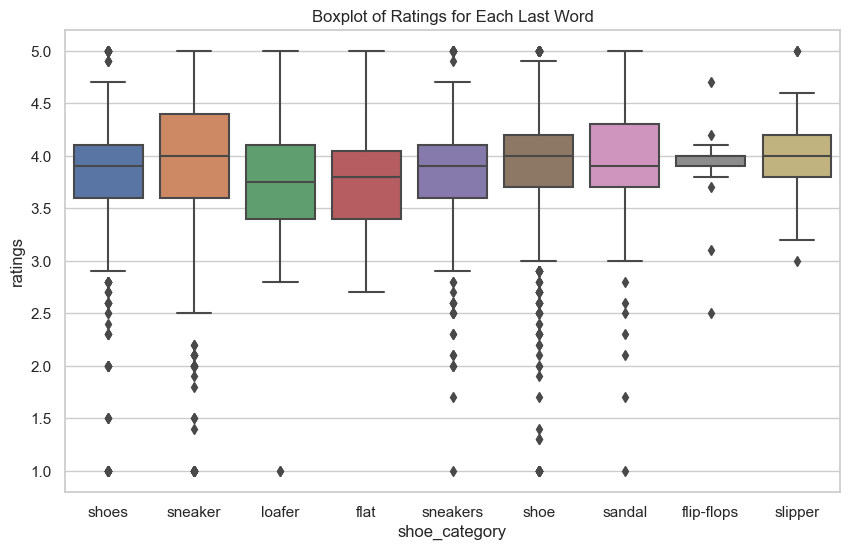

In [93]:
# Assuming your data is in a DataFrame named 'df'
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(x='shoe_category', y='ratings', data=products_new)
plt.title('Boxplot of Ratings for Each Last Word')
plt.show()


Following this, we incorporated "shoe_category" as an additional feature to evaluate its influence on the model's performance. Notably, we limited our consideration to specific subcategories, namely Casual Shoes, Sports Shoes, and Men's Fashion (with shoe type), due to the distinct pattern observed in the last word of other subcategories.

In [94]:
# Split the data into features (X) and target variable (y)
X = products_new.drop(columns=['ratings'])
y = products_new['ratings']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
# Target encode 'sub_category' and 'brand'
target_encoder = TargetEncoder()
X_train[['sub_category', 'brand', 'shoe_category']] = target_encoder.fit_transform(X_train[
            ['sub_category', 'brand', 'shoe_category']], y_train)
X_test[['sub_category', 'brand', 'shoe_category']] = target_encoder.transform(X_test[
            ['sub_category', 'brand', 'shoe_category']])

In [96]:
# Standardize 'no_of_ratings', 'actual_price', 'discount_value'
scaler = StandardScaler()
X_train[['no_of_ratings', 'actual_price', 'discount_value']] = scaler.fit_transform(X_train[
            ['no_of_ratings', 'actual_price', 'discount_value']])
X_test[['no_of_ratings', 'actual_price', 'discount_value']] = scaler.transform(X_test[
            ['no_of_ratings', 'actual_price', 'discount_value']])

In [97]:
X_train.head()

,sub_category,brand,actual_price,discount_value,no_of_ratings,shoe_category
14326,3.828279,3.869643,-0.274275,-0.170103,0.551463,3.822074
12864,3.828279,3.913715,3.533525,5.281753,-0.199204,3.822074
12246,3.863776,3.913715,-0.134539,-0.159386,-0.195980,3.908622
3217,3.635343,3.636898,-1.287359,-0.745299,1.804546,3.822074
12598,3.828279,3.913715,-0.134539,0.379369,-0.177710,3.832797


In [98]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation results
    print(f'{model_name} - Mean Squared Error: {mse}')
    print(f'{model_name} - R-squared: {r2}')
    print()

In [99]:
# Linear Regression
linear_model = LinearRegression()
train_evaluate_model(linear_model, X_train, y_train, X_test, y_test, 'Linear Regression')

Linear Regression - Mean Squared Error: 0.3910793489409745
Linear Regression - R-squared: 0.06148271016760909



In [100]:
# Support Vector Regression (SVR)
svr_model = SVR(kernel='rbf')
train_evaluate_model(svr_model, X_train, y_train, X_test, y_test, 'SVR')

SVR - Mean Squared Error: 0.39055036361707346
SVR - R-squared: 0.06275217600336103



In [101]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
train_evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'Random Forest Regression')

Random Forest Regression - Mean Squared Error: 0.40492450035239597
Random Forest Regression - R-squared: 0.028256936382433984



In [102]:
# XGBoost Regressor
xgb_model = XGBRegressor()
train_evaluate_model(xgb_model, X_train, y_train, X_test, y_test, 'XGBoost Regressor')

XGBoost Regressor - Mean Squared Error: 0.43997491889859636
XGBoost Regressor - R-squared: -0.05585751228520941



Surprisingly, the model's performance decreased, indicating that the inclusion of the "shoe_category" as an additional feature did not lead to an improvement. 

This might be due to the following reasons:
- Less amount of data (4361 rows) makes it difficult to establish robust patterns.
- Consideration of only the shoes category does not imply that the model will underperform / well
perform for other categories.
- We do not consider other sub-categories because of the less amount of data.
- For ratings, external factors such as product quality, product color, shipping duration, durability,
etc. might be significantly important.

### THE END

#### SI 618 FINAL PROJECT BY:
- Nan-Hsin Lin
- Aryan Sharma
- Shreya Jain

<b> Under the guidance of: </b>
- Prof. Chris Teplovs 

GSIs:	
- Arjun Padmanabhan
- Niloufar Sedarati
- Wengran Xiao